In [2]:
from tqdm.notebook import tqdm as tqdm

# Quantum statistical mechanics and Quantum Monte Carlo

![pot](figs/2DCH2NlIEeW7_xJajfx_vw_14bcd7badf4bda1034f054150140256e_plot_A0_potentials.png)

## Particle in a harmonic oscillator $V(x)=\frac{1}{2}m\omega^2x^2$

ground state : $\psi_0(x)=\frac{1}{\pi{1/4}}\exp{-\frac{x^2}{2}}$ 

1st excited state : $\psi_1(x)=\sqrt{2}x\psi_0(x)$ 

Recursion using Hermite polynomials for higher states: $\psi_n(x)=\sqrt{\frac{2}{n}}\psi_{n-1}(x) - \sqrt{\frac{n-1}{n}}\psi_{n-2}(x)$

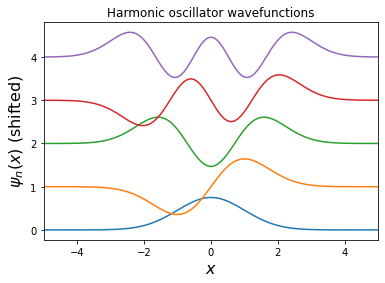

In [5]:
import math, pylab

n_states = 5
grid_x = [i * 0.1 for i in range(-50, 51)]
psi = {}
for x in grid_x:
    psi[x] = [math.exp(-x ** 2 / 2.0) / math.pi ** 0.25]  # ground state
    psi[x].append(math.sqrt(2.0) * x * psi[x][0])         # first excited state
    # other excited states (through recursion):
    for n in range(2, n_states):
        psi[x].append(math.sqrt(2.0 / n) * x * psi[x][n - 1] -
                      math.sqrt((n - 1.0) / n) * psi[x][n - 2])

# graphics output
for n in range(n_states):
    shifted_psi = [psi[x][n] + n  for x in grid_x]  # vertical shift
    pylab.plot(grid_x, shifted_psi)
pylab.title('Harmonic oscillator wavefunctions')
pylab.xlabel('$x$', fontsize=16)
pylab.ylabel('$\psi_n(x)$ (shifted)', fontsize=16)
pylab.xlim(-5.0, 5.0)
pylab.savefig('plot-harmonic_wavefunction.png')
pylab.show()


## Particle in a harmonic potential $V(x)=x^2/2$ in the limit $T \rightarrow 0$

Proba to be at position $x$ and energy level $n$: 

$\pi(x,n) \propto \exp{(-\beta E_n)} \vert \psi_n(x) \vert ^2$, where $\beta=1/k_B T$

For a classical particle:

$\pi(x,n)\propto \exp{(-\beta E_n)}$ 

Boltzmann law infinitely favors small energies with respect to larger energies. At T=0, the system is blocked at the lowest value of the energy.

### Sample ground state using Monte Carlo Markov chain

In [20]:
import random, math, pylab

def psi_0_sq(x):
    # quantum particle wave function in harmonic potential
    psi0 =  math.pi**(-1/4) * math.exp(-x**2/2)
    return psi0**2

    
# delta and number of steps modified for better sampling
x = 0.0
delta = 0.1
xs = []
for k in tqdm(range(1000000)):
    x_new = x + random.uniform(-delta, delta)
    # Metropolis algo acceptance probability :
    # --------------------------------------
    # si acceptance rate = psi_0_sq(x_new) / psi_0_sq(x) est petit
    # alors il faut tirer Upsilon = random.uniform(0.0, 1) plus petit que psi_0_sq(x_new) / psi_0_sq(x)
    # pour que la transition soit acceptée
    if random.uniform(0.0, 1) <  \
         psi_0_sq(x_new) / psi_0_sq(x): 
        x = x_new 
        xs.append(x)


compare sampling histogram to analytical formula

Text(0, 0.5, 'proba density pi(x)')

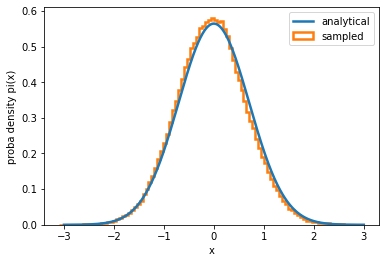

In [21]:
pylab.plot([x/100 for x in range(-300, 300 + 1)], [psi_0_sq(x/100) for x in range(-300, 300 + 1)], lw=2.5, label='analytical')
n, bins, patches = pylab.hist(xs, bins=100, density=True, lw=2.5, histtype='step', label='sampled')
pylab.legend()
pylab.xlabel('x')
pylab.ylabel('proba density pi(x)')

### Sample finite temperature state using Monte Carlo Markov chain

Markov chain alternates moves in position and energy levels

In [26]:
import random, math, pylab

def psi_n_square(x, n):
    '''
    Analytical solution for density of proba using recursion and Hermite polynomials
    '''
    if n == -1:
        return 0.0
    else:
        psi = [math.exp(-x ** 2 / 2.0) / math.pi ** 0.25]
        psi.append(math.sqrt(2.0) * x * psi[0])
        for k in range(2, n + 1):
            psi.append(math.sqrt(2.0 / k) * x * psi[k - 1] -
                       math.sqrt((k - 1.0) / k) * psi[k - 2])
        return psi[n] ** 2
    
def markov_chain_MC_finite_T(beta):
    x = 0.0
    n = 0
    delta = 0.1
    xs = []
    for k in tqdm(range(5000000)):

        # attempt change in x
        x_new = x + random.uniform(-delta, delta)
        # Metropolis algo acceptance probability 
        if random.uniform(0.0, 1) <  \
             psi_n_square(x_new, n) / psi_n_square(x, n): 
            x = x_new 
            xs.append(x) # record sampled position

        # attempt energy shift
        E = n + 0.5
        n_new = n + random.randrange(-1, 2, 2) # +/-1
        E_new = n_new + 0.5
        if E_new > 0:
            # Metropolis algo acceptance probability 
            if random.uniform(0.0, 1) <  \
                 (psi_n_square(x, n_new) / psi_n_square(x, n))*math.exp(-beta*(E_new - E)): 
                n = n_new
    return xs

Comparison with theory:
    
Classical : $\pi(x) = \sqrt{\beta/2\pi}\exp(-\beta x^2/2)$

Quantum : $\pi(x) = \sqrt{\tanh(\beta/2)/\pi}\exp(-x^2\tanh(\beta/2))$

In [30]:
beta = 0.2
xs = markov_chain_MC_finite_T(beta)

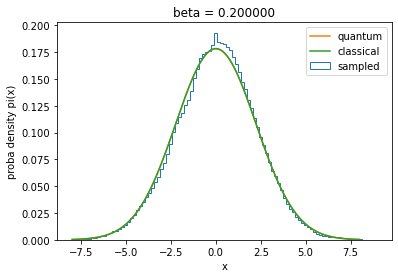

In [31]:
n, bins, patches = pylab.hist(xs, bins=100, density=True, histtype='step', label='sampled')
x_range = 8*100
pylab.plot([x/100 for x in range(-x_range, x_range + 1)],
           [math.sqrt(math.tanh(beta/2)/math.pi)*math.exp(-(x/100)**2*math.tanh(beta*0.5))
            for x in range(-x_range, x_range + 1)], label='quantum')
pylab.plot([x/100 for x in range(-x_range, x_range + 1)],
           [math.sqrt(beta/(2*math.pi))*math.exp(-beta*0.5*(x/100)**2) 
            for x in range(-x_range, x_range + 1)], label='classical')
pylab.xlabel('x')
pylab.ylabel('proba density pi(x)')
pylab.title('beta = %f'% beta)
pylab.legend()


$\beta=1$ : difference between quantum and classical theory but sampling still favors classical

In [33]:
beta = 1
xs = markov_chain_MC_finite_T(beta)

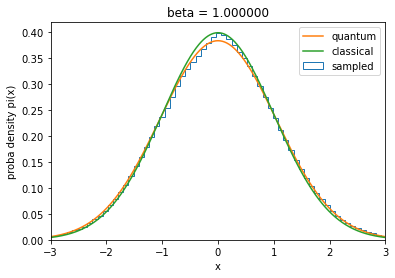

In [35]:
n, bins, patches = pylab.hist(xs, bins=100, density=True, histtype='step', label='sampled')
x_range = 8*100
pylab.plot([x/100 for x in range(-x_range, x_range + 1)],
           [math.sqrt(math.tanh(beta/2)/math.pi)*math.exp(-(x/100)**2*math.tanh(beta*0.5))
            for x in range(-x_range, x_range + 1)], label='quantum')
pylab.plot([x/100 for x in range(-x_range, x_range + 1)],
           [math.sqrt(beta/(2*math.pi))*math.exp(-beta*0.5*(x/100)**2) 
            for x in range(-x_range, x_range + 1)], label='classical')
pylab.xlim(-3,3)
pylab.xlabel('x')
pylab.ylabel('proba density pi(x)')
pylab.title('beta = %f'% beta)
pylab.legend()

$\beta=5$ : sampling in agreement with quantum theory, proba density is more spread out than classical prediction

In [36]:
beta = 5
xs = markov_chain_MC_finite_T(beta)

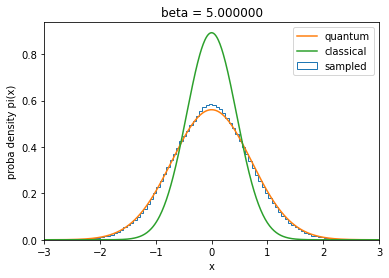

In [37]:
n, bins, patches = pylab.hist(xs, bins=100, density=True, histtype='step', label='sampled')
x_range = 8*100
pylab.plot([x/100 for x in range(-x_range, x_range + 1)],
           [math.sqrt(math.tanh(beta/2)/math.pi)*math.exp(-(x/100)**2*math.tanh(beta*0.5))
            for x in range(-x_range, x_range + 1)], label='quantum')
pylab.plot([x/100 for x in range(-x_range, x_range + 1)],
           [math.sqrt(beta/(2*math.pi))*math.exp(-beta*0.5*(x/100)**2) 
            for x in range(-x_range, x_range + 1)], label='classical')
pylab.xlim(-3,3)
pylab.xlabel('x')
pylab.ylabel('proba density pi(x)')
pylab.title('beta = %f'% beta)
pylab.legend()

## Density matrix

Proba to be at position $x$ and energy level $n$: 

$\pi(x,n) \propto \exp{(-\beta E_n)} \vert \psi_n(x) \vert ^2$, where $\beta=1/k_B T$
... is usually impossible to compute

Introduce **density matrix** by summing over energy levels:

$\rho(x,x',\beta) = \sum_n e^{-\beta E_n}\psi_n(x)\psi_n^{*}(x')$

**Probability density $\pi(x)$** is given by diagonal density matrix and **partition function Z** (number of legal configurations):

$\pi(x)=\frac{\rho(x,x,\beta)}{Z}$

and $Z=\text{Tr}(\rho)=\int_{\mathbb{R}} dx\rho(x,x,\beta)$

### Properties of density matrices :

**Convolution :**

$\int dx'\rho(x,x',\beta)\rho(x',x'',\beta) = \rho(x',x'',2\beta)$ obtain density matrix at lower temperature

**Trotter decomposition at high T :**

$\rho(x,x',\beta) = e^{-\beta V(x)/2}\rho^{\text{free}}(x,x',\beta)e^{-\beta V(x')/2}$

### Free density matrix (potential V=0)

For a free particle, Schrodinger equation writes:

$H^{\text{free}}\psi = -\frac{1}{2}\frac{\partial^{2}}{\partial x^2}\psi = E\psi$

Solutions in a box of width $L$:

$\psi_0(x) = 1/\sqrt{L}$

$\psi_n^{sym}(x) = \sqrt{2/L}\sin(2\pi n x /L)$

$\psi_n^{antisym}(x) = \sqrt{2/L}\cos(2\pi n x /L)$

$E_n=2\pi^2n^2/L^2$

reinjecting in density matrix definition and for $L \rightarrow \infty$, one finds:

$\rho^{\text{free}}(x,x',\beta)=\frac{1}{\sqrt{2\pi \beta}}\exp{(-\frac{(x-x')^2}{2\beta})}$ (setting $\hbar = m = 1$)

In [52]:
import math, pylab

# density matrix for a free particle (exact)
def funct_rho_free(x, xp, beta):
    return (math.exp(-(x - xp) ** 2 / (2.0 * beta)) /
            math.sqrt(2.0 * math.pi * beta))

def density_matrices(beta):
    '''
    Free density matrix and harmonic potential density matrix
    '''

    nx = 300
    L = 10.0
    x = [-L / 2.0 + i * L / float(nx - 1) for i in range(nx)]
    rho_free, rho_harm = [], []
    for i in range(nx):
        # free density matrix
        rho_free.append([funct_rho_free(x[i], x[j], beta) for j in range(nx)])
        # density matrix for a harmonic potential (using Trotter decomposition)
        rho_harm.append([rho_free[i][j] * math.exp(- beta * x[i] ** 2 / 4.0 -
                         beta * x[j] ** 2 / 4.0) for j in range(nx)])
    
    return rho_free, rho_harm, L

At small $\beta$, off-diagonal terms in $\rho^{\text{free}}(x,x',\beta)=\frac{1}{\sqrt{2\pi \beta}}\exp{(-\frac{(x-x')^2}{2\beta})}$ vanish, and the density matrix is peaked along its diagonal

Text(0.5, 1.0, '$\\beta$=0.01 (harm)')

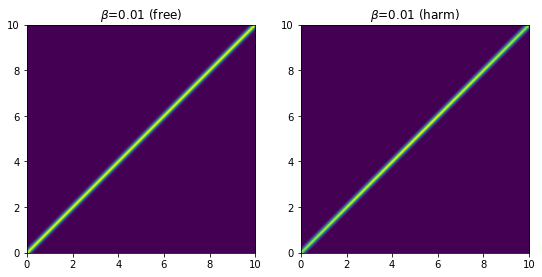

In [81]:
beta = 0.01
rho_free, rho_harm, L = density_matrices(beta)

f, axarr = pylab.subplots(1,2, figsize=(9, 6)) 
axarr[0].imshow(rho_free, extent=[0.0, L, 0.0, L], origin='lower')
axarr[0].set_title('$\\beta$=%s (free)' % beta)
axarr[1].imshow(rho_harm, extent=[0.0, L, 0.0, L], origin='lower')
axarr[1].set_title('$\\beta$=%s (harm)' % beta)

higher $\beta$

position is more constrained in a harmonic potential

Text(0.5, 1.0, '$\\beta$=0.1 (harm)')

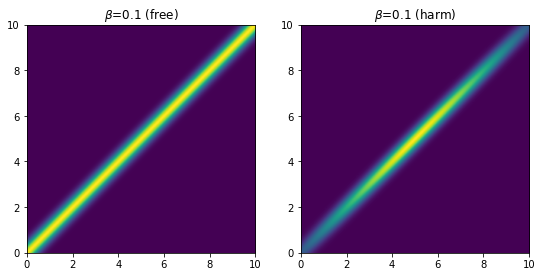

In [82]:
beta = 0.1
rho_free, rho_harm, L = density_matrices(beta)

f, axarr = pylab.subplots(1,2, figsize=(9, 6)) 
axarr[0].imshow(rho_free, extent=[0.0, L, 0.0, L], origin='lower')
axarr[0].set_title('$\\beta$=%s (free)' % beta)
axarr[1].imshow(rho_harm, extent=[0.0, L, 0.0, L], origin='lower')
axarr[1].set_title('$\\beta$=%s (harm)' % beta)

high $\beta$, quantum effects appear (thermal de Broglie wavelength ~ interparticle distance)

more confinement in harmonic potential

Text(0.5, 1.0, '$\\beta$=1 (harm)')

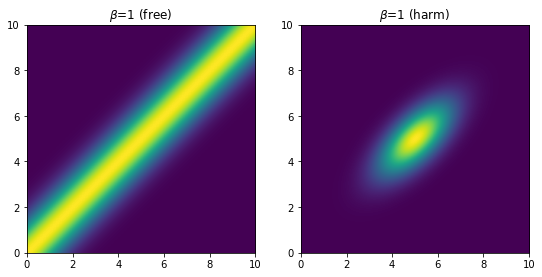

In [85]:
beta = 1
rho_free, rho_harm, L = density_matrices(beta)

f, axarr = pylab.subplots(1,2, figsize=(9, 6)) 
axarr[0].imshow(rho_free, extent=[0.0, L, 0.0, L], origin='lower')
axarr[0].set_title('$\\beta$=%s (free)' % beta)
axarr[1].imshow(rho_harm, extent=[0.0, L, 0.0, L], origin='lower')
axarr[1].set_title('$\\beta$=%s (harm)' % beta)

### Compute density matrix at high $\beta$ using matrix squaring

beta: 0.03125 -> 0.0625
beta: 0.0625 -> 0.125
beta: 0.125 -> 0.25
beta: 0.25 -> 0.5
beta: 0.5 -> 1.0
beta: 1.0 -> 2.0
beta: 2.0 -> 4.0


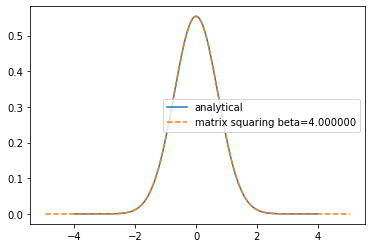

In [94]:
import math, numpy

# Free off-diagonal density matrix
def rho_free(x, xp, beta):
    return (math.exp(-(x - xp) ** 2 / (2.0 * beta)) /
            math.sqrt(2.0 * math.pi * beta))

# Harmonic density matrix in the Trotter approximation (returns the full matrix)
def rho_harmonic_trotter(grid, beta):
    # 0.5 * (x ** 2 + xp ** 2) = harmonic potential
    return numpy.array([[rho_free(x, xp, beta) * \
                         numpy.exp(-0.5 * beta * 0.5 * (x ** 2 + xp ** 2)) \
                         for x in grid] for xp in grid])

x_max = 5.0
nx = 100
dx = 2.0 * x_max / (nx - 1)
x_matrix_squaring = [i * dx for i in range(int(-(nx - 1) / 2), int(nx / 2 + 1))]
beta_tmp = 2.0 ** (-5)                   # initial value of beta (power of 2)
beta     = 2.0 ** 2                      # actual value of beta (power of 2)
rho = rho_harmonic_trotter(x, beta_tmp)  # density matrix at initial beta

while beta_tmp < beta:
    rho = numpy.dot(rho, rho) #matrix squaring
    rho *= dx
    beta_tmp *= 2.0
    print ('beta: %s -> %s' % (beta_tmp / 2.0, beta_tmp))

Z = sum(rho[j, j] for j in range(nx )) * dx # Z = Tr(rho)
pi_of_x = [rho[j, j] / Z for j in range(nx )] #pi(x) = rho(x,x)/Z

#f = open('data_harm_matrixsquaring_beta' + str(beta) + '.dat', 'w')
#for j in range(nx):
#    f.write(str(x[j]) + ' ' + str(rho[j, j] / Z) + '\n')
#f.close()

x_range = 400
pylab.plot([x/100 for x in range(-x_range, x_range + 1)],
           [math.sqrt(math.tanh(beta/2)/math.pi)*math.exp(-(x/100)**2*math.tanh(beta*0.5)) 
            for x in range(-x_range, x_range + 1)], label='analytical')
pylab.plot(x_matrix_squaring, pi_of_x, '--', label='matrix squaring beta=%f'%beta)
pylab.legend()

## Path integral Monte Carlo

Density matrix written as a  **path integral**

$\rho(x_0, x_N, \beta)=\int dx_0...dx_N \rho(x_0,x_N,\beta/N)...\rho(x_{N-1},x_N,\beta/N)$

where $dx_0...dx_N$ are paths and $\rho(x_0,x_N,\beta/N)...\rho(x_{N-1},x_N,\beta/N)$ are weights

Using Trotter decomposition for each weight:

$...\rho(x_{k-1}, x_{k}, \Delta_{\tau})\rho(x_{k}, x_{k+1}, \Delta_{\tau})... = ...e^{- \Delta_{\tau}V(x_{k-1})}\rho^{free}(x_{k-1}, x_{k}, \Delta_{\tau})e^{- \Delta_{\tau}V(x_{k})}e^{- \Delta_{\tau}V(x_{k})}\rho^{free}(x_{k}, x_{k+1}, \Delta_{\tau})e^{- \Delta_{\tau}V(x_{k+1})}...$

where $\Delta_{\tau} = \beta/N$

#### Naive sampling of positions:
Attempt moves in x and use Metropolis algorithm for local path sampling :

$\mathbb{P}(x_k \rightarrow x^{'}_{k})=\min{(1, \frac{\pi(a)}{\pi(b)})} = \frac{\rho^{free}(x_{k-1}, x_{k}, \Delta_{\tau})\rho^{free}(x_{k}, x_{k+1}, \Delta_{\tau})e^{-0.5\Delta_{\tau}x_k^2}}{\rho^{free}(x_{k-1}, x^{'}_{k}, \Delta_{\tau})\rho^{free}(x^{'}_{k}, x_{k+1}, \Delta_{\tau})e^{-0.5\Delta_{\tau}x_{k}^{'2}}} $

![path](figs/snapshot_00008.png)

In [96]:
import math, random

def rho_free(x, y, beta):    # free off-diagonal density matrix
    return math.exp(-(x - y) ** 2 / (2.0 * beta)) 

beta = 4
N = 8                                             # number of slices
dtau = beta / N
delta = 1.0                                       # maximum displacement on one slice
n_steps = 10000000                                 # number of Monte Carlo steps
x = [0.0] * N                                     # initial path
x0s = []

for step in tqdm(range(n_steps)):
    k = random.randint(0, N - 1)                  # random slice
    knext, kprev = (k + 1) % N, (k - 1) % N       # next/previous slices
    x_new = x[k] + random.uniform(-delta, delta)  # new position at slice k
    old_weight  = (rho_free(x[knext], x[k], dtau) *
                   rho_free(x[k], x[kprev], dtau) *
                   math.exp(-0.5 * dtau * x[k] ** 2))
    new_weight  = (rho_free(x[knext], x_new, dtau) *
                   rho_free(x_new, x[kprev], dtau) *
                   math.exp(-0.5 * dtau * x_new ** 2))
    # Metroplis acceptance rule
    if random.uniform(0.0, 1.0) < new_weight / old_weight:
        x[k] = x_new
    if step%10 == 0:
        x0s.append(x[7])


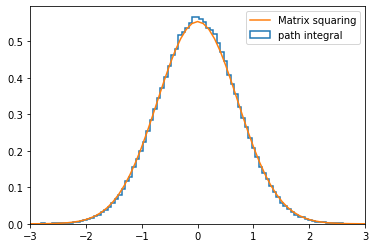

In [101]:
_,_, _ = pylab.hist(x0s, bins=100, density=True, lw=1.5, histtype='step', label='path integral')
pylab.plot(x_matrix_squaring,pi_of_x, label='Matrix squaring')
pylab.xlim(-3,3)
pylab.legend()

## Particle in an anharmonic oscillator $V(x)=\frac{x^2}{2} + cx^3 + dx^4$

In [125]:
import math, numpy

# Free off-diagonal density matrix
def rho_free(x, xp, beta):
    return (math.exp(-(x - xp) ** 2 / (2.0 * beta)) /
            math.sqrt(2.0 * math.pi * beta))

def anharmonic_V(x, cubic, quartic):
    # return V(x) for a given x
    return x ** 2 / 2.0 + cubic * x ** 3 + quartic * x ** 4

# Harmonic density matrix in the Trotter approximation (returns the full matrix)
def rho_anharmonic_trotter(grid, beta):
    # 0.5 * (x ** 2 + xp ** 2) = harmonic potential
    return numpy.array([[rho_free(x, xp, beta) * \
                         numpy.exp(-0.5*beta*(anharmonic_V(x, cubic, quartic) + anharmonic_V(xp, cubic, quartic))) \
                         for x in grid] for xp in grid])

x_max = 5.0
nx = 100
dx = 2.0 * x_max / (nx - 1)
x_sq = [i * dx for i in range(int(-(nx - 1) / 2), int(nx / 2 + 1))]

cubic =  -1
quartic = 1


Text(0.5, 1.0, 'Anharmonic potential')

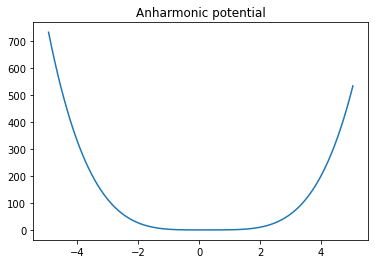

In [126]:
pylab.plot(x_sq, [anharmonic_V(z, cubic, quartic) for z in x_sq])
pylab.title('Anharmonic potential')

beta: 0.03125 -> 0.0625
beta: 0.0625 -> 0.125
beta: 0.125 -> 0.25
beta: 0.25 -> 0.5
beta: 0.5 -> 1.0
beta: 1.0 -> 2.0
beta: 2.0 -> 4.0


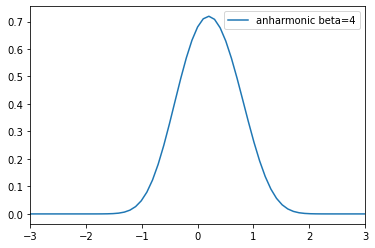

In [127]:
beta_tmp = 2.0 ** (-5)                   # initial value of beta (power of 2)
beta     = 2.0 ** 2                      # actual value of beta (power of 2)
rho = rho_anharmonic_trotter(x, beta_tmp)  # density matrix at initial beta
while beta_tmp < beta:
    rho = numpy.dot(rho, rho) #matrix squaring
    rho *= dx
    beta_tmp *= 2.0
    print ('beta: %s -> %s' % (beta_tmp / 2.0, beta_tmp))

Z = sum(rho[j, j] for j in range(nx )) * dx # Z = Tr(rho)
pi_of_x = [rho[j, j] / Z for j in range(nx )] #pi(x) = rho(x,x)/Z

pylab.plot(x_sq, pi_of_x, label='anharmonic beta=4')
pylab.xlim(-3,3)
pylab.legend()

In [117]:
import math, random

def rho_free(x, y, beta):    # free off-diagonal density matrix
    return math.exp(-(x - y) ** 2 / (2.0 * beta)) 

def anharmonic_V(x, cubic, quartic):
    # return V(x) for a given x
    return x ** 2 / 2.0 + cubic * x ** 3 + quartic * x ** 4

beta = 4
N = 16                                             # number of slices
dtau = beta / N
delta = 1.0                                       # maximum displacement on one slice
n_steps = 1000000                                 # number of Monte Carlo steps
x = [0.0] * N                                     # initial path
x0s = []
cubic =  -1
quartic = 1


for step in tqdm(range(n_steps)):
    k = random.randint(0, N - 1)                  # random slice
    knext, kprev = (k + 1) % N, (k - 1) % N       # next/previous slices
    x_new = x[k] + random.uniform(-delta, delta)  # new position at slice k
    old_weight  = (rho_free(x[knext], x[k], dtau) *
                   rho_free(x[k], x[kprev], dtau) *
                   math.exp(-dtau * anharmonic_V(x[k], cubic, quartic)))
    new_weight  = (rho_free(x[knext], x_new, dtau) *
                   rho_free(x_new, x[kprev], dtau) *
                   math.exp(-dtau * anharmonic_V(x_new, cubic, quartic)))
    if random.uniform(0.0, 1.0) < new_weight / old_weight:
        x[k] = x_new
#    print (x)
    if step%10 == 0:
        x0s.append(x[0])


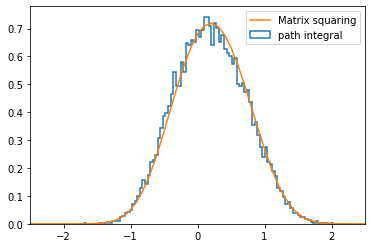

In [129]:
_,_, _ = pylab.hist(x0s, bins=100, density=True, lw=1.5, histtype='step', label='path integral')
pylab.plot(x_sq, pi_of_x, label='Matrix squaring')
pylab.xlim(-2.5, 2.5)
pylab.legend()

### Perturbative calculus

In [130]:
import math, numpy

# Free off-diagonal density matrix
def rho_free(x, xp, beta):
    return (math.exp(-(x - xp) ** 2 / (2.0 * beta)) /
            math.sqrt(2.0 * math.pi * beta))

def Energy_pert(n, cubic, quartic):
    return n + 0.5 - 15.0 / 4.0 * cubic **2 * (n ** 2 + n + 11.0 / 30.0) \
         + 3.0 / 2.0 * quartic * (n ** 2 + n + 1.0 / 2.0)

def Z_pert(cubic, quartic, beta, n_max):
    Z = sum(math.exp(-beta * Energy_pert(n, cubic, quartic)) for n in range(n_max + 1))
    return Z

def anharmonic_V(x, cubic, quartic):
    # return V(x) for a given x
    return x ** 2 / 2.0 + cubic * x ** 3 + quartic * x ** 4

# Harmonic density matrix in the Trotter approximation (returns the full matrix)
def rho_anharmonic_trotter(grid, beta, cubic, quartic):
    # 0.5 * (x ** 2 + xp ** 2) = harmonic potential
    return numpy.array([[rho_free(x, xp, beta) * \
                         numpy.exp(-0.5*beta*(anharmonic_V(x, cubic, quartic) + anharmonic_V(xp, cubic, quartic))) \
                         for x in grid] for xp in grid])

x_max = 5.0
nx = 100
dx = 2.0 * x_max / (nx - 1)
x = [i * dx for i in range(int(-(nx - 1) / 2), int(nx / 2 + 1))]
beta_tmp = 2.0 ** (-5)                   # initial value of beta (power of 2)
beta     = 2.0 ** 1                      # actual value of beta (power of 2)

Zs = []
Z_perts = []
for quartic in [1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5]:
    cubic = -quartic
    rho = rho_anharmonic_trotter(x, beta_tmp, cubic, quartic)  # density matrix at initial beta
    while beta_tmp < beta:
        rho = numpy.dot(rho, rho) #matrix squaring
        rho *= dx
        beta_tmp *= 2.0
        print ('beta: %s -> %s' % (beta_tmp / 2.0, beta_tmp))

    Z = sum(rho[j, j] for j in range(nx )) * dx # Z = Tr(rho)
    
    Zs.append(Z)
    n_max = 5
    Z_perts.append(Z_pert(cubic, quartic, beta, n_max))

beta: 0.03125 -> 0.0625
beta: 0.0625 -> 0.125
beta: 0.125 -> 0.25
beta: 0.25 -> 0.5
beta: 0.5 -> 1.0
beta: 1.0 -> 2.0


#### Checking that $Z = \sum_n \exp(-\beta E_n) = \int dx \rho(x,x,\beta)$

for high temperatures only

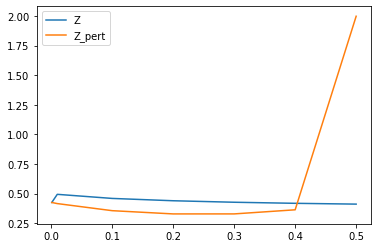

In [131]:
pylab.plot([1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5], Zs, label='Z')
pylab.plot([1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5], Z_perts, label = 'Z_pert')
#pylab.yscale('log')
pylab.legend()

In [154]:
for a, z,zp in zip([1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5], Zs,Z_perts):
    print(a, '|', z,'|', zp)

0.001 | 0.42439334618910324 | 0.4243628427829461
0.01 | 0.4932119117202093 | 0.4150517026377626
0.1 | 0.4586545206649605 | 0.3551514714440175
0.2 | 0.4389872122616267 | 0.32775877164453204
0.3 | 0.4263343738551318 | 0.32784612873323904
0.4 | 0.4173115899353957 | 0.36255007135063205
0.5 | 0.41052841619431585 | 1.9976121853765039
